References:

1. Generative Deep Learning - David Foster
2. Variational Autoencoder: Intuition and Implementation - Agustinus Kristiadi
3. Deep Learning with Python - Francois Chollet

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import datasets

In [12]:
from model import ScNN

In [90]:
#takes a list of flattened image data and plots the image list in rows
def plotImage(x_img, cols=5):
  #pick five random indices from the sample range of the image data
  random_sample_indices = [np.random.randint(low=0, high=x_img[0].shape[0]) for i in range(5)]
  #select the five images
  random_sample_images = x_img[0][random_sample_indices, :]

  #number of rows to be plotted
  rows = len(x_img)
  #create subplot axes
  fig, ax = plt.subplots(nrows=rows, ncols=cols, squeeze=False)

  for row in range(rows):
    for i, index in enumerate(random_sample_indices):
      #the image pixels are in flattened array
      #reshape the pixel array to 28*28 dimension
      ax[row, i].imshow(x_img[row][index].reshape(28,28), cmap='gray')
      ax[row, i].grid=False
      ax[row, i].set_xticks([])
      ax[row, i].set_yticks([])

  return ax, fig

# Generating Dataset

In [15]:
def generateTrajectory(t, b, k, units=50, samples=100):
  #assert b < 2*np.sqrt(k)
  A0 = 1
  m = 1

  xt_series = np.zeros(units*samples).reshape(samples, units)

  omega = np.sqrt(k/m - (b/(2*m))**2)
  xt_series = A0*np.exp(-b*t/(2*m))*np.cos(omega*t)

  return xt_series

In [16]:
def generateData(t0=0, t1=5, t0_ques=0, t1_ques=10, b0= 0.5, b1=1, k0=5, k1=10, units=50, samples=500, random=True):
  assert b1 < 2*np.sqrt(k0)

  t = np.linspace(t0, t1, units).reshape(1, units)
  #xt_series = np.zeros((samples, units))
  t_ques = np.random.uniform(low=t0_ques, high=t1_ques, size=(samples,1))
  #x_ans = np.zeros(samples)

  if random:
    b = np.random.uniform(low=b0, high=b1, size=(samples,1))
    k = np.random.uniform(low=k0, high=k1, size=(samples,1))
  else:
    b = np.linspace(b0, b1, samples).reshape(-1,1)
    k = np.linspace(k0, k1, samples).reshape(-1,1)

  #omega = np.sqrt(k - b**2/4)
  xt_series = generateTrajectory(t, b, k, units=units, samples=samples)
  #np.exp(-b*t/2)*np.cos(omega*t)
  x_ans = generateTrajectory(t_ques, b, k, units=1, samples=samples)
  #np.exp(-b*t_ques)*np.cos(omega*t_ques)

  return t, xt_series, t_ques, x_ans

In [17]:
samples = 100000
t_train, xt_train, t_pred, x_ans = generateData(samples=samples)

In [10]:
#t_pred = t_pred.reshape(-1,1)
#x_ans = x_ans.reshape(-1,1)

print(t_pred.shape)
print(x_ans.shape)
print(t_train.shape)
print(xt_train.shape)

(100000, 1)
(100000, 1)
(1, 50)
(100000, 50)


# Building Model

In [11]:
#dfine a sampling subclass of Layer
#the Sampling layer takes two inputs: mean and log_sigma
#the layer samples random samples from mean and log_sigma assuming that the mean and log_sigma are from from a gaussian distribution
class Sampling(keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, inputs):
    #unpack the inputs
    mean, log_var = inputs
    batch_size = tf.shape(mean)[0]
    #size of the latent layer
    units = tf.shape(mean)[1]
    #generate random samples from a gaussian distribution of mean=0 and standard deviation=1
    epsilon = tf.random.normal(shape=(batch_size, units), mean=0, stddev=1)
    #shift and scale epsilon
    return mean + tf.math.exp(log_var/2)*epsilon

## Encoder

The encoder takes as input time series of 50 positions of the pendulum.

The encoder consists of two hidden layers of different dimensions. Next, two layers for $mean$ and $\log(variance)$. Each of the two have dimension `latent_dim`, which is the dimension the latent layer. The output of the latent layer is sampled from normal distributions using the outputs of the layers `z_mean` and `z_log_var` as means and $\log(variance)$ of the gaussian distributions.

In [44]:
class Encoder(keras.layers.Layer):
    def __init__(self, latent_size=3, layer_size=[70, 70], vae=True, **kwargs):
        super().__init__(**kwargs)
        self.layer_size = layer_size
        self.latent_size = latent_size
        self.vae = vae
        
        self.encoder_layer = []
        
        for i in range(len(self.layer_size)):
            self.encoder_layer.append(Dense(layer_size[i], activation='elu', name=('encoder_layer'+str(i+1))))

        if self.vae:
            self.mean = Dense(latent_size, name='mean')
            self.log_var = Dense(latent_size, name='log_sigma')
            #generate random samples from gaussian distribution with mean = mean and log(variance) = log_var
            self.z = Sampling(name='sampling_layer')
        else:
            self.z = Dense(latent_size, name='latent_layer')

    def call(self, inputs):
        x = inputs
        for i in range(len(self.layer_size)):
            x = self.encoder_layer[i](x)

        if self.vae:
            mean = self.mean(x)
            log_var = self.log_var(x)
            z = self.z([mean, log_var])
            return mean, log_var, z
        else:
            z = self.z(x)
            return z

## Decoder

The decoder consists of hidden layers and an output layer. The input to the decoder is the gaussian sample output of the encoder and a question through question layer. The output is the answer to the question given the representation of the observation as the output of the encoder.

In [45]:
class Decoder(keras.layers.Layer):
    def __init__(self, layer_size=[70, 70], output_size=1, **kwargs):
        super().__init__(**kwargs)
        self.layer_size = layer_size
        self.output_size = output_size
        
        self.decoder_layer = []
        for i in range(len(self.layer_size)):
            self.decoder_layer.append(Dense(layer_size[i], activation='elu', name=('encoder_layer'+str(i+1))))

        self.decoder_output = Dense(output_size, name='decoder_layer_out')

    def call(self, inputs):
        x = inputs
        for i in range(len(self.layer_size)):
            x = self.decoder_layer[i](x)

        x = self.decoder_output(x)
        return x

In [46]:
#create a subclass VAE of Model
#the model takes encoder and decoder models and joins them to build beta-VAE
#the model defines a training method to train the beta-VAE model so constructed
"""Variables in the class object:

   encoder               --   encoder model to produce mean and log_var as output from the input
   decoder               --   decoder model to produce the output
   reconstruction_loss   --   total loss for the output accuracy of the decoder - sum over total outputs and average over samples
   kl_loss               --   total loss for the kl-metric - sum over output units of latent layer and average over samples
   total_loss            --   reconstruction_loss + kl_loss
   beta_rec              --   parameter to control the relative significance of reconstruction loss
   beta_kl               --   parameter to control the relative significance of kl-divergence loss
"""

class VAE(Model):
    #
    def __init__(self, input_size=50, encoder_layer=[70, 70], latent_size=3, question_size=1, decoder_layer=[70, 70], output_size=1, beta_rec=500., beta_kl=1., target_var=0.01, **kwargs):
        super().__init__(**kwargs)
      
        self.encoder = Encoder(layer_size=encoder_layer, latent_size=latent_size, vae=True, name='encoder')
        self.concatenate = keras.layers.Concatenate()
        self.decoder = Decoder(layer_size=decoder_layer, output_size=output_size, name='decoder')

        self.beta_rec = beta_rec
        self.beta_kl = beta_kl
        self.target_var = target_var

        #define the losses
        #Mean stores the mean value of the argument passed to it and a name for the mean value
        self.total_loss = keras.metrics.Mean(name='total_loss')
        self.total_reconstruction_loss = keras.metrics.Mean(name='reconstruction_loss')
        self.total_kl_loss = keras.metrics.Mean(name='kl_loss')

    #return the losses to be printed during training
    @property
    def metrics(self):
        return [self.total_loss, self.total_reconstruction_loss, self.total_kl_loss]
    
    #feeds an output of encoder and question to the decoder and returns the outputs of encoder and decoder
    #encoder input and a question is passed as input
    def call(self, inputs):
        observation, question = inputs
        mean, log_var, z = self.encoder(observation)
        decoder_input = self.concatenate([z, question])
        predictions = self.decoder(decoder_input)

        return mean, log_var, z, predictions

    #training method called when called to fit
    #the method is passed a set of observation, a question for each observation and the corresponding answers
    def train_step(self, data):
        inputs = data['time_series']
        question = data['t_question']
        outputs = data['answer']

        with tf.GradientTape() as tape:
            #feed-forward step
            #calls the call() method
            mean, log_var, z, predictions = self([inputs, question])
            
            #calculate losses for the current feed-forward step
            #outputs and predictions are one dimensional so only take mean over samples
            reconstruction_loss = self.beta_rec*tf.reduce_mean(tf.reduce_sum((outputs - predictions)**2, axis=1))
            #take sum over dimension and mean over samples
            #kl_loss = 0.5*self.beta_kl*tf.reduce_mean(tf.reduce_sum(tf.square(z_mean) + 2*tf.exp(z_log_sigma) -  2*z_log_sigma, axis=1))
            kl_loss = 0.5*self.beta_kl*tf.reduce_mean(tf.reduce_sum(tf.square(mean)/self.target_var + tf.exp(log_var)/self.target_var - log_var + tf.math.log(self.target_var), axis=1)-3)
            loss = reconstruction_loss + kl_loss

            #calculates gradients w.r.t. the trainable weights of the model
            gradients = tape.gradient(loss, self.trainable_weights)
            #updates the trainable weights using the gradients calculated
            #method to update the weights is passed in call to compile function of the model as optimizer parameter
            self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

            #updates the current losses
            self.total_reconstruction_loss.update_state(reconstruction_loss)
            self.total_kl_loss.update_state(kl_loss)
            self.total_loss.update_state(loss)

            #return the losses name and the corresponding values
            return {m.name: m.result() for m in self.metrics}

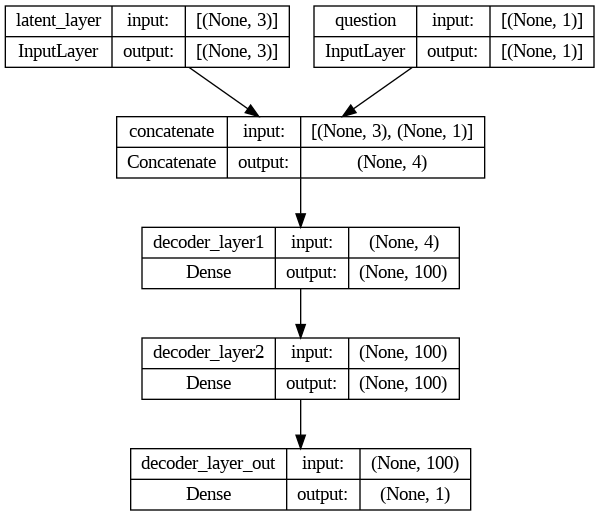

In [ ]:
keras.utils.plot_model(decoder, show_shapes=True)

# Train Model

Each sample in the training consists of a time series of 50 positions of pendulum, the prediction time as a question and the corresponding answer to the question, which is the position o fthe pendulum.

A large sample is generated by varying the frequency and the damping parameter fo the pendulum. The parameters are randomly chosen in the specified range.

In [13]:
#(self, input_size=50, encoder_layer=[70, 70], latent_size=3, question_size=1, decoder_layer=[70, 70], output_size=1, beta_rec=500., beta_kl=1., target_sigma=0.1, **kwargs)
pendulum = ScNN(input_size=50, encoder_layer=[70,70], latent_size=3, question_size=1, decoder_layer=[70, 70], output_size=1, beta_rec=500., beta_kl=1.0e-1)

In [18]:
epochs = 100
batch_size = 500
learning_rate = 1.0e-3

pendulum.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
pendulum.fit({'time_series': xt_train, 't_question': t_pred, 'answer': x_ans}, batch_size=batch_size, epochs=epochs)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 6.9224 - reconstruction_loss: 75.0667 - total_loss: 81.9891
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0348 - reconstruction_loss: 34.2361 - total_loss: 34.2709
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0257 - reconstruction_loss: 32.6200 - total_loss: 32.6457
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0324 - reconstruction_loss: 29.3029 - total_loss: 29.3353
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0795 - reconstruction_loss: 22.3759 - total_loss: 22.4554
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.1001 - reconstruction_loss: 18.7229 - total_loss: 18.8230
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.1304 - reconstruction_loss: 16.2856 - total_loss: 16.4160
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.2059 - reconstruction_loss: 14.1474 - total_loss: 14.3533
Epoch 9/

# Validating the model

The test sample is similarly generated. The answer to the question is predicted by the model for each sample.

In [ ]:
test_samples = 10000
t_test, xt_test, t_test_pred, x_test_ans = generateData(samples=samples)

In [ ]:
z_mu, z_logvar, z, x_test_prediction = pendulum.predict([xt_test, t_test_pred])

31250/31250 [==============================] - 63s 2ms/step


In [ ]:
z.mean(axis=0)

array([-0.00120292, -0.00144639,  0.00434577], dtype=float32)

In [ ]:
x_test_ans = x_test_ans.reshape(-1,1)

In [ ]:
def MSE(x_pred, x_ans, batch_size=10):
  mse = 0
  start = 0
  end = batch_size
  num_batches = int(x_pred.shape[0]/batch_size)

  for batch in range(num_batches):
    mse = (np.square(x_pred[start:end] - x_ans[start:end])).sum()
    start += batch_size
    end += batch_size

  return mse.mean()

In [ ]:
mse = MSE(x_test_prediction, x_test_ans, batch_size=1000)

ValueError: operands could not be broadcast together with shapes (1000,1) (200,1) 

In [ ]:
mu = x_test_ans.mean()
mu

0.004429453935575459

In [ ]:
np.sqrt(mse)

In [19]:
t0, t1 = 0, 5
b0, b1 = 0.5, 1
k0, k1 = 5, 10
N_grid = 50

B = np.linspace(b0, b1, N_grid)
K = np.linspace(k0, k1, N_grid)

b_grid, k_grid = np.meshgrid(B, K)
b_grid = b_grid.flatten().reshape(-1,1)
k_grid = k_grid.flatten().reshape(-1,1)

t = np.linspace(t0, t1, 50).reshape(1,-1)

#layer_z = []
layer_mean = []
#layer_log_sigma = []

for i in range(3):
  #layer_z.append(np.zeros(N_grid**2))
  layer_mean.append(np.zeros(N_grid**2))
  #layer_log_sigma.append(np.zeros(N_grid**2))

xt_series = generateTrajectory(t, b_grid, k_grid, units=50, samples=N_grid**2)
mean, log_sigma, z = pendulum.encoder(xt_series)

for i in range(3):
  layer_mean[i] = mean[:,i].numpy().reshape((N_grid, N_grid))

b_grid = b_grid.reshape(N_grid, N_grid)
k_grid = k_grid.reshape(N_grid, N_grid)

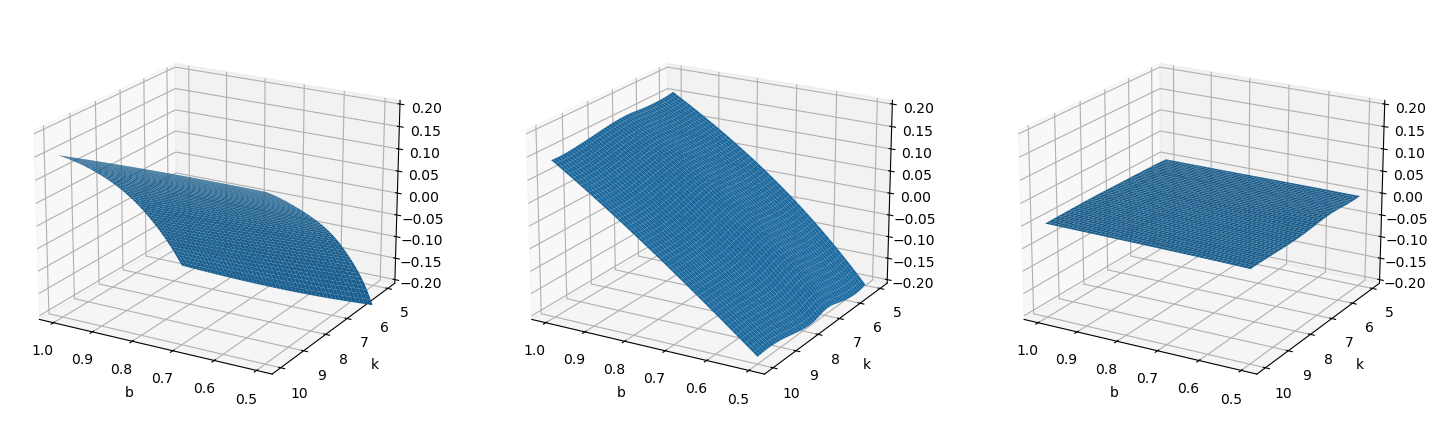

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': '3d'}, figsize=(18,10))

for i in range(3):
  ax[i].plot_surface(b_grid, k_grid, layer_mean[i])
  ax[i].set_xlabel('b')
  ax[i].set_ylabel('k')
  ax[i].view_init(20,120)
  ax[i].set_zlim3d(-0.20,0.20)

plt.show()

Below, the model is provided a time series of position as an observation and the position of the pendulum is asked for a range of time to obtain the predicted trajectory of the pendulum.

In [21]:
#generate observation data and test samples with a fixed value of spring constant and damping parameter
samples = 200
t_obs = np.linspace(0, 5, 50).reshape(1,-1)
t_ques = np.linspace(0, 10, samples).reshape(-1, 1)
#observation data
x_obs = generateTrajectory(t_obs, 0.5, 5, units=50, samples=1)
#test questions as array of times and the corresponding answer as the position of the pendulum
x_true_ans = generateTrajectory(t_ques, 0.5, 5, units=1, samples=samples)

In [22]:
z_mu = np.zeros(samples*3).reshape(samples, 3)
z_logvar = np.zeros(samples*3).reshape(samples, 3)
z = np.zeros(samples*3).reshape(samples, 3)
#array to store the predicted answers of the model
x_pred_ans = np.zeros(samples).reshape(1,samples)

#generate answer to each questions
z_mu, z_logvar, z, x_pred_ans = pendulum.predict([np.broadcast_to(x_obs, shape=(samples, 50)), t_ques])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[]

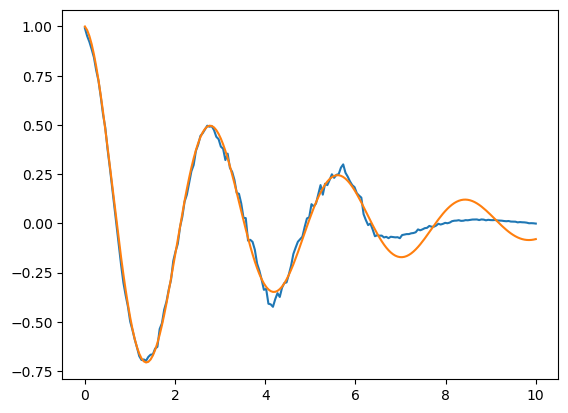

In [23]:
plt.plot(t_ques, x_pred_ans)
plt.plot(t_ques, x_true_ans)
plt.plot()

#Denoising using Autoencoder

In [ ]:
variational_autoencoder = VAE(encoder, decoder, beta_rec=10., beta_kl=1)
variational_autoencoder.compile(optimizer='adam')
variational_autoencoder.fit(x_train_reshaped, x_train_reshaped, batch_size=128, epochs=10)

In [ ]:
latent_z_mu, latent_z_logvar, x_prediction_reshaped = variational_autoencoder.predict(x_test_reshaped)

Let us introduce some noise to the images and see how the autoencoder performs on the noised images.

In [ ]:
#create noises for the training and test datasets as random values
train_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_train_reshaped.shape[1]))
test_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_test_reshaped.shape[1]))

In [ ]:
#add the noise
x_train_noise = x_train_reshaped + train_noise
x_test_noise = x_test_reshaped + test_noise
#clip the noise in the range [0,1]
x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

We see that the encoder is performing badly for the noised data. This is because the encoder is not trained to remove the noise. So, lets pass the encoder noised data and train it to produce denoised images.